# Logistic Regression on More than Two Labels

Last time we studied *logistic regression*, a supervised learning algorithm which trains a model to predict labels of feature vectors. Our formulation only made sense for data with two possible labels (say, labels in $\{0,1\}$). In many real-world applications, data could have many more than two possible labels. Our goal is to generalize the logistic regression algorithm to data with many labels.

## Motivating Example

Recall the `iris` dataset, containing biological measurements for samples of a few different flower species. 

In [1]:
import seaborn as sns # sns is the standard abbreviation for seaborn

iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


The dataset contains flowers from three different species, as we can see below. This means that the labels for this data naturally fall into three categories, say, $\{0,1,2\}$. 

In [2]:
iris.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

If we create a scatterplot for the features, we see that the data is pretty well-separated by label.

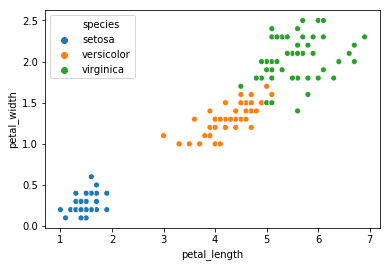

In [4]:
sns.scatterplot(x="petal_length", y="petal_width",
                hue="species", data=iris)

We can therefore hope that a generalized version of logistic regression would be able to classify all of the species labels.

## Problem Statement

### Logistic Regression

Last time we studied *logistic regression*; this is a regression algorithm on data consisting of
- A set of feature vectors $X = \{\vec{x}_1,\ldots,\vec{x}_n\}$, each $\vec{x}_j \in \mathbb{R}^d$
- A set of labels $Y = \{y_1,\ldots,y_n\}$, each $y_j \in \{0,1\}$. 
The goal is to find a function $f:\mathbb{R}^d \rightarrow [0,1]$ such that $f(\vec{x})$ predicts the probability that a feature vector $\vec{x}$ should be labeled $1$. 

The regression problem is solve by finding weights $\beta_1,\ldots, \beta_d, b$ minimizing the loss function
$$
L(\beta_1,\ldots,\beta_d,b) = -\frac{1}{n} \sum_j \big[y_j \log(f(\vec{x}_j)) + (1-y_j)\log(1-f(\vec{x}_j)) \big],
$$
where $f(\vec{x}) = S(g(\vec{x}))$, with $g$ the linear function
$$
g(\vec{x}) = \beta_1 x^1 + \cdots + \beta_d x^d + b
$$
and $S$ the *sigmoid function* (or *logistic function*)
$$
S(a) = \frac{1}{1 + \exp(-a)}.
$$
This optimal collection of weights is found via gradient descent, or some variant of it.

### Increasing the Number of Labels

Now suppose we have data of the form
- A set of feature vectors $X = \{\vec{x}_1,\ldots,\vec{x}_n\}$, each $\vec{x}_j \in \mathbb{R}^d$
- A set of labels $Y = \{y_1,\ldots,y_n\}$, each $y_j \in \{0,1,\ldots,K\}$, $K \geq 1$. I.e., now there are $K+1$ labels that we would like to predict!

The goal is now to find a function 
$$
f:\mathbb{R}^d \rightarrow [0,1] \times [0,1] \cdots \times [0,1],
$$
where the range has $K+1$ copies of the interval $[0,1]$. Moreover, we want the output to be a *probability vector*. That is, if $f(\vec{x}) = \vec{p}$, with $\vec{p} = (p^0,p^1,\ldots, p^K)$ satisfying
$$
\sum_{j=0}^K p^j = 1.
$$
We could use such a function to label feature vectors via the rule
$$
\mathrm{label}(\vec{x}) = \mathrm{argmax}_j \{p_j\},
$$
i.e., the feature recieves the label with the highest probability.

### Formulating an Algorithm: SoftMax Regression

The precise statement of the problem falls into a familiar paradigm: we want to fix a class of relevant predictor functions, parameterized by some weights, then minimize a loss function on those weights. This is done by a rather direct generalization of the logistic regression formulation.

We now have a collection of weights for each label. Denote the weights for label $j$ by $\beta^{(j)}_1, \ldots, \beta^{(j)}_d, b^{(j)}$. For each label $j$, we then get a linear function $g^{(j)}$ defined on $\vec{x} = (x^1,\ldots,x^d)$ by
$$
g^{(j)}(\vec{x}) = \beta^{(j)}_1 x^1 + \cdots + \beta^{(j)}_d x^d + b^{(j)}.
$$
Finally, we define 
$$
p^j(\vec{x}) = \frac{\exp(g^{(j)}(\vec{x}))}{\sum_{\ell=0}^K \exp(g^{(\ell)}(\vec{x}))}.
$$
Note that $p^j(\vec{x}) \in [0,1]$. We interpret this as the probability that $\vec{x}$ has label $j$. Our prediction function is then given by
$$
f(\vec{x}) = \vec{p}(\vec{x}) = \left(p^0(\vec{x}),p^1(\vec{x}),\ldots,p^K(\vec{x})\right).
$$

Let $B$ denote the collection of all $\beta^{(j)}_\ell$ (so $B$ contains $d\cdot K$ weights) and let
$$
b = (b^{(0)},\ldots,b^{(K)})
$$
denote the vector of offsets (sometimes called *biases*). We seek to optimize the following loss function
$$
L(B,b) = -\frac{1}{n} \sum_{j=1}^n \sum_{\ell = 0}^K \delta_{j\ell} \log(p^\ell(\vec{x}_j)),
$$
where
$$
\delta_{j\ell} = \left\{\begin{array}{cc}
1 & y_j = \ell \\
0 & \mbox{otherwise.} \end{array}\right.
$$
This loss function $L$ is sometimes called the *cross entropy function*.

### Theoretical Homework

Check that this reduces to the standard logistic regression problem when the labels are $\{0,1\}$.

### Solving the Regression Problem

The cross entropy function is a differentiable function $L:\mathbb{R}^{dK + K} \rightarrow \mathbb{R}$. It is convex and therefore has a unique minimum. However, it is not possible to solve for the minimum analytically. Luckily, one can compute the gradient $\nabla L$ explicitly and we can therefore minimize the loss via gradient descent (or some variant thereof). Once again, let's use built-in functions from `scikit-learn`, rather than coding this gradient descent by hand.

## SoftMax Regression on the Iris Dataset

Let's train and test a model to classify all 3 flower species in the `iris` dataset.

In [6]:
# Import some useful functions
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

Let's get our data. The explanatory variables are 'petal_length' and 'petal_width' (so there are two features, and each element of our set $X$ is a vector in $\mathbb{R}^2$). We also need to get the set $y$ consisting of labels for all of the flower species. The `scikit-learn` package has a built-in function to take a vector of 'categorical variables' (i.e., labels) and turn it into a vector of integers.

In [7]:
X = iris[['petal_length','petal_width']]

In [8]:
y = iris.species.astype("category").cat.codes

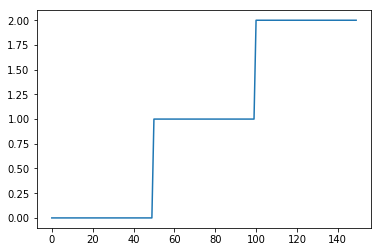

In [9]:
# Plotting the label vector shows that we have correctly labelled things as 0,1,2
plt.plot(y)

As usual, to test the performance of logistic regression for this classification problem, we will split our data into a 'testing set' and a 'training set'.

In [10]:
# Construct the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Check the sizes of the sets
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(112, 2)
(38, 2)
112
38


Now we will fit the logistic regression model to our training data. Notice that we have to specify a `multi_class` option (otherwise we will get a warning). The `multinomial` option uses the cross entropy function, as described above. 

In [11]:
model = LogisticRegression(solver='lbfgs', multi_class = 'multinomial', max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

The weight coefficients $\beta^{(j)}_\ell$ and $b^{(j)}$ are given below. There should be 
$$
dK + K = 2\cdot 3 + 3 = 9
$$
numbers in total.

In [12]:
model.coef_, model.intercept_

(array([[-2.53497386, -1.02624743],
        [ 0.10855954, -0.81556404],
        [ 2.42641431,  1.84181147]]),
 array([ 10.12484865,   2.69393459, -12.81878324]))

So our probability functions are defined for $j=0,1,2$ by
$$
p^j(\vec{x}) = \frac{\exp(g^{(j)}(\vec{x}))}{\sum_{\ell=0}^K g^{(\ell)}(\vec{x})},
$$
with
\begin{align*}
g^{(0)}(\vec{x}) &= -2.535 x^1 - 1.026 x^2 + 10.125 \\
g^{(1)}(\vec{x}) &= 0.10855954 x^1 -0.81556404 x^2 + 2.69393459\\
g^{(2)}(\vec{x}) &= 2.42641431 x^1 +  1.84181147 x^2 -12.81878324
\end{align*}

Let's take a look at how these probability functions evaluate on some subset of our testing data.

In [13]:
print(X_test[0:5])
print(y_test[0:5])

     petal_length  petal_width
14            1.2          0.2
98            3.0          1.1
75            4.4          1.4
16            1.3          0.4
131           6.4          2.0
14     0
98     1
75     1
16     0
131    2
dtype: int8


In [14]:
model.predict_proba(X_test[0:5])

array([[9.85464688e-01, 1.45352392e-02, 7.31322573e-08],
       [3.24098804e-01, 6.73498850e-01, 2.40234616e-03],
       [9.18888507e-03, 8.23517051e-01, 1.67294064e-01],
       [9.80353933e-01, 1.96458551e-02, 2.12049664e-07],
       [4.77349241e-07, 9.60039561e-03, 9.90399127e-01]])

In [15]:
for j in range(5):
    print('Sum of row:', sum(model.predict_proba(X_test[0:5])[j]))

Sum of row: 0.9999999999999999
Sum of row: 1.0
Sum of row: 0.9999999999999999
Sum of row: 1.0
Sum of row: 1.0


Each row above gives the three probabilities that the correct label is 0, 1 or 2, respectively. If we take the max in each row, then the predicted labels agree with the true ones! Indeed, this can be done with a single command.

In [16]:
model.predict(X_test[0:5])

array([0, 1, 1, 0, 2], dtype=int8)

So our model mades some correct predictions! We can plot each of the probability functions over the full data set. 

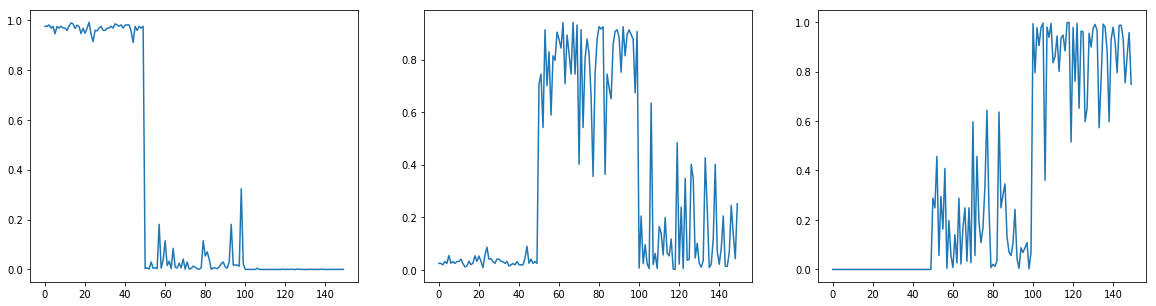

In [17]:
fig = plt.figure(figsize=(20,5))

for j in range(3):
    fig.add_subplot(1,3,j+1)
    plt.plot(model.predict_proba(X)[:,j])

plt.show()

This looks like a pretty convincing split between the flower species. Some observations:
- In the function on the left, everything in class 2 has essentially zero probability of being labelled as class 0
- For the function in the middle and one the right, there is a very low probability of assigning the label 0
- For the function in the middle (probability that the label is 1), there are several things with true label 2, but which have high values.

The model still performs really well in the classification task, but not perfectly, as we see by the following scores.

In [18]:
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

0.9732142857142857
0.9736842105263158


To see what was predicted correctly/incorrectly, we can look at the *confusion matrix*. For a general multiclass classification problem with labels $0,1,\ldots,K$, the confusion matrix is the $(K+1) \times (K+1)$ matrix
$$
C = (C_{ij}) = \left(\begin{array}{cccc}
C_{00} & C_{01} & \cdots & C_{0K} \\
C_{10} & C_{11} & \cdots & C_{1K} \\
\vdots & \vdots & & \vdots \\
C_{K0} & C_{K1} & \cdots & C_{KK} \end{array}\right)
$$
with entry $C_{ij}$ giving the number of observations known to be in group $i$ and predicted to be in group $j$.

This can be computed via `scikit-learn` as follows.

In [19]:
from sklearn import metrics
predicted = model.predict(X_test)
metrics.classification_report(y_test, predicted)
print(metrics.confusion_matrix(y_test, predicted))

[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]


This shows that in the test set almost everything was classified correctly, except one flower with true label 1 was predicted to have label 2. 

We can similarly compute the confusion matrix on the training set.

In [20]:
predicted = model.predict(X_train)
metrics.classification_report(y_train, predicted)
print(metrics.confusion_matrix(y_train, predicted))

[[37  0  0]
 [ 0 32  2]
 [ 0  1 40]]


### Exercise

Rerun the above experiments using features `sepal_length` and `sepal_width`. Before fitting the model, plot the data. Do you expect better or worse classification results? 

### Exercise

Play with parameters in the toy data generator below until you get a picture that looks interesting, then train and test a logistic regression model on it. Save your model as `model` (for use in the next part).

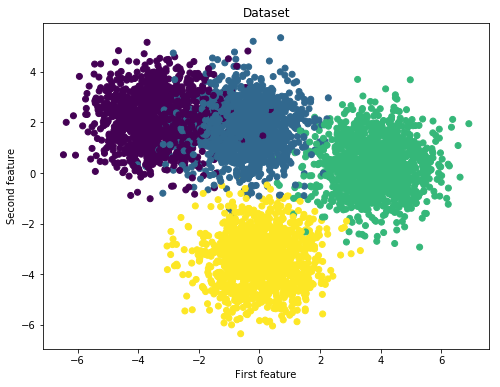

In [57]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(centers=4, n_samples = 5000, center_box = [-4,4], random_state=7)

fig = plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y)
plt.title("Dataset")
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()

# Exercise, continued

Determine what the code below is doing. (Try switching the parameter `label`.) You may have to adjust some other parameters to get a nice looking plot, depending on what parameters you used to generate your data.

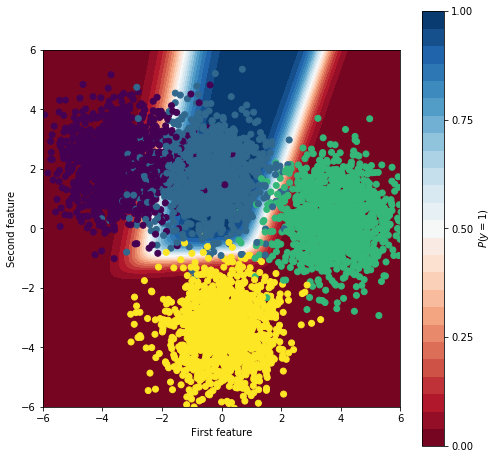

In [61]:
import numpy as np
label = 1

xx, yy = np.mgrid[-6:6:.01, -6:6:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, label].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 8))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[:,0], X[:,1], c=y)

ax.set(aspect="equal",
       xlim=(-6, 6), ylim=(-6, 6),
       xlabel="First feature", ylabel="Second feature");

## The MNIST dataset



The `scikit-learn` package includes a collection of toy
datasets, including the ever-popular MNIST database (Modified
National Institute of Standards and Technology database), a database
of handwritten digits. MNIST is used as a standard testing ground and benchmark when studying machine learning algorithms. 

The data is highly preprocessed to center the
handwritten digits, threshold the bitmaps, etc.


In [73]:
from sklearn import datasets
digits = datasets.load_digits()

In [74]:
type(digits)

sklearn.utils.Bunch

'Bunch' is a dictionary-type object. Let's take a look at what is in there.

In [75]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
         [ 0.,  0., 13., ..., 15.,  5.,  0.],
         [ 0.,  3., 15., ..., 11.,  8.,  0.],
         ...,
         [ 0.,  4., 11., ..., 12.,  7.,  0.],
         [ 0.,  2., 14., ..., 12.,  0.,  0.],
         [ 0.,  0.,  6., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
         [ 0.,  0.,  0., ...,  9.,  0.,  0.],
         [ 0.,  0.,  3., ...,  6.,  0.,  0.],
         ...,
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  0., ..., 10.,  0.,  0.]],
 
        [[ 0

The images are available under `digits.images`. The labels of the digits are in `digits.target`.



In [76]:
images = digits.images
print(type(images))
print(images.shape)

<class 'numpy.ndarray'>
(1797, 8, 8)


In [77]:
target = digits.target
target[:20]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Each image is an $8 \times 8$ array of numbers between 0 and 16,
inclusive.  Let's take a look at the first few examples.



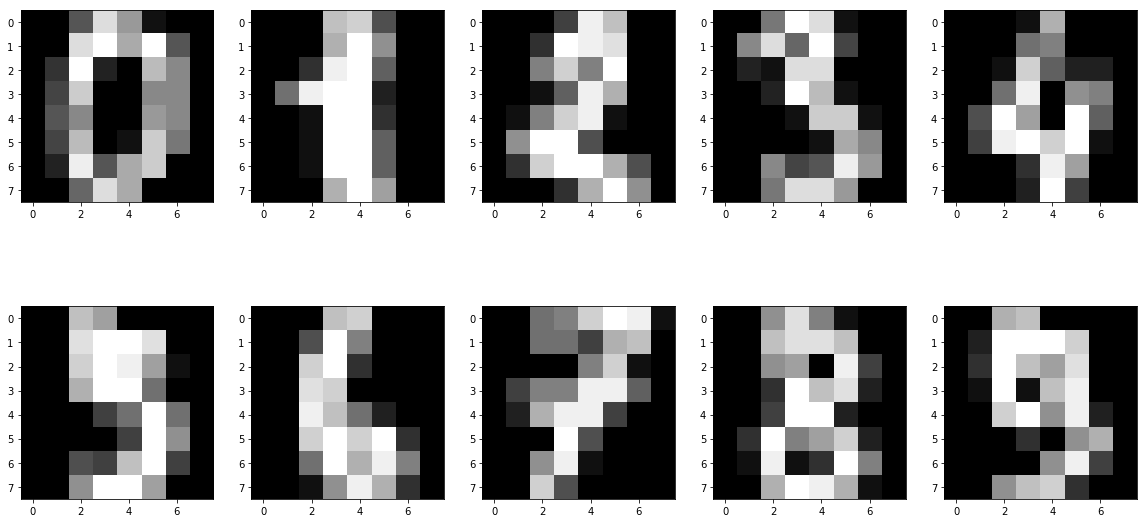

In [78]:
fig = plt.figure(figsize=(20,10))

for j in range(10):
    fig.add_subplot(2,5,j+1)
    plt.imshow(digits.images[j], cmap='gray')
    # imshow is a useful function. 
    # It treats an array of numbers as an image, with the number in each entry 
    # corresponding to a color.

We can treat each image as a vector in $\mathbb{R}^{8 \times 8} \approx \mathbb{R}^{64}$. Conveniently, `digits.data` reshapes each image into a 64 dimensional vector.

In [79]:
print(digits.data[0])
print(images[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


### Exercise

Create a logistic regression model to classify digits in the MNIST dataset. Fit the model to a training set, then test it on a testing set. Compute the classification rates and the confusion matrix.

In [91]:
model = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [92]:
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

1.0
0.9533333333333334


### Exercise, continued

If you save store your confusion matrix as `array`, the following code will give you a fancier-looking figure.

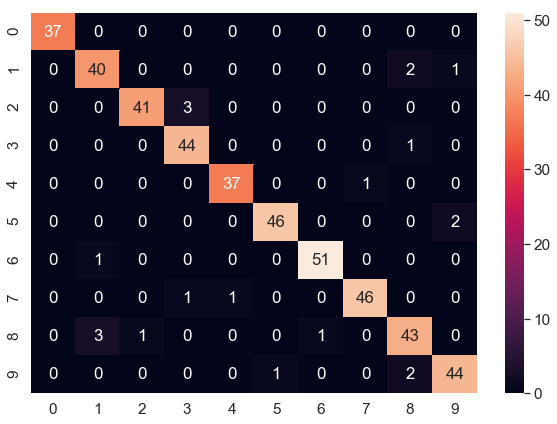

In [85]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
     
df_cm = pd.DataFrame(array, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True)

## Examining the Coefficients

Once the classification model has been created, we have a list of coefficients for each label. Let's try to visualize what those coefficients are telling us about our data.

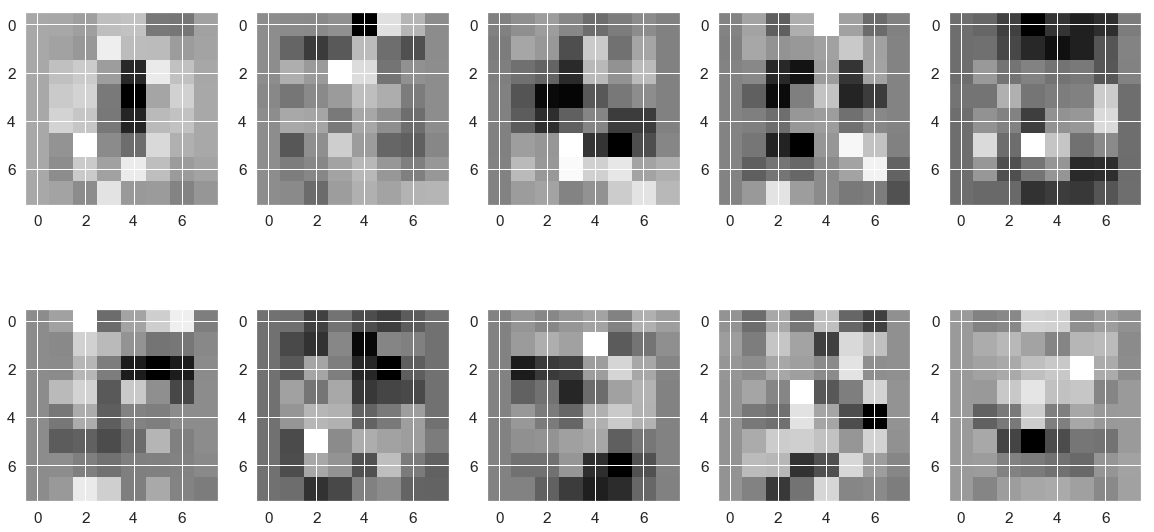

In [96]:
fig = plt.figure(figsize=(20,10))

for j in range(10):
    fig.add_subplot(2,5,j+1)
    plt.imshow(model.coef_[j].reshape(8,8), cmap='gray')

## $\ell_1$ Regularization

The `scikit-learn` logistic regression solver doesn't actually minimize the cross entropy function, but an $\ell_2$-regularized version. In the $2$-label setting, the loss function looks like
$$
\widehat{L}\left(\vec{\beta},b\right) = \|\vec{\beta}\|^2 + L(\vec{\beta},b),
$$
where $L(\vec{\beta},b)$ is our usual loss function and $\|\cdot\|$ is the Euclidean norm on $\mathbb{R}^d$. This penalizes large weights, which can help to avoid overfitting in the model.

Different types of regularization can be used. For example, the following code fits a model for the MNIST dataset with $\ell_1$ regularization, which has loss of the form
$$
\widetilde{L}\left(\vec{\beta},b\right) = \|\vec{\beta}\|_1 + L(\vec{\beta},b),
$$
where $\|\cdot\|_1$ is the $\ell_1$-norm
$$
\|(x_1,x_2,\ldots,x_d)\|_1 = |x_1| + |x_2| + \cdots + |x_d|.
$$

### Exercise

Fit the model, then study the effect. Does it change classification rate? How are the weight coefficients affected by the choice of regularization? What might be the point of this?

Note that I named the model `modelL1` so it won't overwrite the previous model.

In [93]:
modelL1 = LogisticRegression(solver='saga', multi_class = 'multinomial', max_iter=10000, penalty='l1')
modelL1.fit(X_train, y_train)
#Note that we have to change the solver to `saga` to use this regularization.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

# $k$-Nearest Neighbors Classification

There are many other approaches to classification, which we will continue to study. For now, let's look at one of the simpler methods. 

Each of our MNIST digits is represented as a vector in $\mathbb{R}^{64}$. There is a natural way to measure distance in $\mathbb{R}^d$ for any $d$: *Euclidean distance* between vectors $\vec{v}, \vec{w} \in \mathbb{R}^d$ is given by
$$
d(\vec{v},\vec{w}) = \| \vec{v} - \vec{w}\|.
$$
Here $\|\cdot\|$ denotes the *Euclidean norm*; for $\vec{x} = (x_1,\ldots,x_d)$, we have
$$
\|\vec{x}\| = \sqrt{x_1^2 + \cdots + x_d^2}
$$

The *$k$-Nearest Neighbors classification algorithm* is simple. To determine the class of a sample $\vec{x}$, we look for the $k$ nearest points in the dataset with respect to Euclidean distance. The most common label amongst those neighbors is then assigned to $\vec{x}$. 

Let's try it on MNIST.

In [103]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.98


Observations:
- This simple method does even better than logistic regression! In general, comparative performance of the models will depend on the application (i.e. kNN does worse than LR on some data).

- The fitting essentially takes no time, because all
`fit` does is store all the training data.  This results in &ldquo;large&rdquo;
models that require quite a bit memory.  

- For large datasets, `predict` is slow
if there are many points, because it is costly to search for nearby
neighbors.

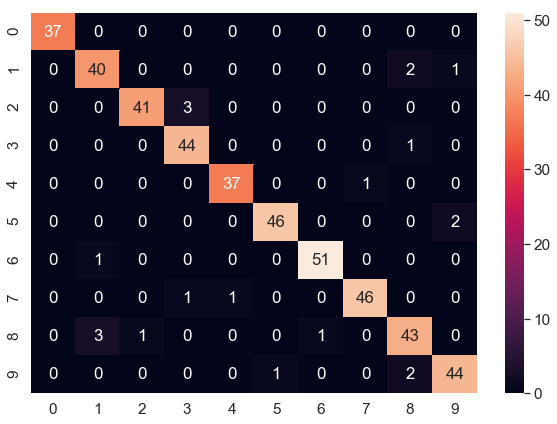

In [104]:
array = metrics.confusion_matrix(y_test, predicted)

df_cm = pd.DataFrame(array, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True)

Another interesting thing about $k$-NN classification is that it doesn't actually require knowledge of the **vectors**, just the **distances** between them. This means that $k$-NN is well-defined in general metric spaces which may not be vector spaces. 

A *metric* is just a way to measure distance between pairs of points in some set (the *metric space*). More precisely, if the set is $X$, then the metric is a function $d:X \times X \rightarrow \mathbb{R}$ satisfying certain 'distance-like' axioms (see https://en.wikipedia.org/wiki/Metric_space).

Some alternative metrics on $\mathbb{R}^d$ are built in to `scikit-learn`. A list of them is available here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

### Exercise

Experiment with $k$-NN classification of MNIST by changing the parameters. In particular:

1) What happens if you change the number of neighbors? Make a plot of the classification rate over various values of $k$. 

2) Try some other metrics on $\mathbb{R}^{64}$. Which metric does the *worst* job?

### Exercise

Load the 'Olivetti faces' dataset https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces. You can do this using the commands

`from sklearn.datasets import fetch_olivetti_faces`

`data = fetch_olivetti_faces()`

** Warning: ** This is a larger file and will take a minute to download. 

Train and test models for facial recognition based on this dataset. Try both logistic regression and $k$-NN. Which approach works better? Which pairs of faces confuse your models? For logistic regression, can you visualize what the coefficients are telling you?